In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import cvxpy as cp
import math

## Data Upload and Cleaning

In [157]:
mast_dem_df = pd.read_csv("/Users/wesle/OneDrive/Senior Year/Thesis/mast_dem_left_shift.csv")

In [158]:
makes = mast_dem_df["Make and Model"].to_list()
quarters = list(mast_dem_df.columns.values)
quarters.remove("Make and Model")

q_num = np.linspace(0, 95, 96)
q_vect = q_num.reshape(96, 1)
quarter_count = mast_dem_df['Quarter Count'].to_numpy()

In [159]:
dem_df = mast_dem_df.drop(columns=['Make and Model', 'Quarter Count'])
dem_arr = dem_df.to_numpy()

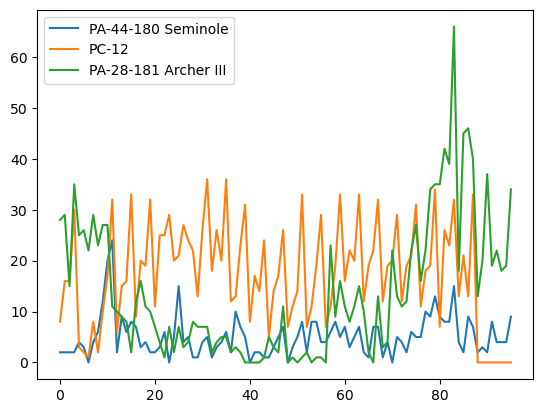

In [160]:
plt.plot(q_num, dem_arr[0], label = makes[0])
plt.plot(q_num, dem_arr[1], label = makes[1])
plt.plot(q_num, dem_arr[2], label = makes[2])
plt.legend()

In [161]:
output_fits = pd.DataFrame(columns=['Plane', 'Additive', 'Dampened Additive', 'Multiplicative', 'Dampened Multiplicative', 'Seasonal Additive', 'Dampened Seasonal Additive', 'Seasonal Multiplicative', 'Dampened Seasonal Multiplicative'])
output_trials = pd.DataFrame(columns=['Plane', 'Additive', 'Dampened Additive', 'Multiplicative', 'Dampened Multiplicative', 'Seasonal Additive', 'Dampened Seasonal Additive', 'Seasonal Multiplicative', 'Dampened Seasonal Multiplicative'])
plane_count = 186
output_fits['Plane'] = makes[0:plane_count]
output_trials['Plane'] = makes[0:plane_count]

## Additive Trend Model

In [162]:
## Full run of the additive error model with selected parameters - everything above this is just testing
def additive_trend_model(plane, fore_dur, trials, alpha, show_plots, MASE_dist):
    ## THIS PART HOLD REGARDLESS OF MODEL
    plane_dem = dem_arr[plane]
    ## Initialization
    f10_dem = plane_dem[0:10]
    f10_quart = np.linspace(0, 9, 10).reshape(10,1)
    linreg = LinearRegression().fit(f10_quart, f10_dem)
    f10_int = linreg.intercept_
    f10_slope = linreg.coef_

    ## Create Variables
    n = plane_dem.shape[0]
    left_shift = n - quarter_count[plane]
    fore = left_shift + fore_dur
    y = plane_dem
    y_hat = np.zeros(n - fore)
    l = np.zeros(n - fore)
    b = np.zeros(n - fore)
    error = np.zeros(n - fore)
    y_hat[0] = f10_int
    l[0] = f10_int
    b[0] = f10_slope
    y_fit = np.zeros(n-fore)

    ## Create fitted estimate and calculate parameters
    AIC_fit = np.inf

    for be in range(1, int(alpha * 100)):
        beta_t = be/100
        ## -------------------------------------------------------------------
        for t in range(1, n - fore):
            y_hat[t] = l[t-1] + b[t-1]
            error[t] = y[t] - y_hat[t]
            l[t] = l[t-1] + b[t-1] + alpha*error[t]
            b[t] = b[t-1] + beta_t*error[t]
            if error[t - 1] == 0:
                error[t - 1] = 0.01
        AIC_trial = (n-fore) * math.log(np.sum(np.power(error, 2))) + (2 * np.sum(math.log(1))) + 2*(2+2)
        ## -------------------------------------------------------------------
        if AIC_trial < AIC_fit:
            AIC_fit = AIC_trial
            beta = beta_t
            y_fit = y_hat[:]


    ## Calculate in-sample MAE
    error_naive = np.zeros(quarter_count[plane] - MASE_dist)
    for t in range(MASE_dist, quarter_count[plane]):
        error_naive[t - MASE_dist] = np.abs(y[t] - y[t - MASE_dist])
    MAE = np.sum(error_naive)/(error_naive.shape[0])


    ## Predict Future Demand
    def state_space_sample(MAE):
        l_a = np.zeros(fore_dur + 1)
        b_a = np.zeros(fore_dur + 1)
        y_hat_a = np.zeros(fore_dur +1)
        dist = np.random.normal(0, 1, 1000)

        l_a[0] = l[n - fore - 1]
        b_a[0] = b[n - fore - 1]
        y_hat_a[0] = y_hat[n - fore - 1]
        ## ------------------------------------------------------------------------
        for t in range(1, fore_dur + 1):
            l_a[t] = l_a[t-1] + b_a[t-1] + alpha * np.random.choice(dist)
            b_a[t] = b_a[t-1] + beta * np.random.choice(dist)
            y_hat_a[t] = l_a[t-1] + b_a[t-1]
        ## ------------------------------------------------------------------------
        ## Compute AIC of this model
        error_fore = y[n - fore - 1 + MASE_dist] - y_hat_a[MASE_dist]
        scaled_error = np.abs(error_fore/MAE)
        return y_hat_a, scaled_error
    
    scaled_error_trial = 0
    ## plot everything - fitted up to prediction
    if (show_plots == True):
        plt.figure(figsize=(4,4))
        plt.plot(q_num, plane_dem, label = "Historical Sales Data")
        plt.plot(q_num[0:n - fore], y_fit, label="Fitted Estimate", linewidth=0.5)
        for i in range(0, trials):
            plt.plot(q_num[n - fore - 1:n - left_shift], state_space_sample(MAE)[0], color='black')
        plt.legend()
        plt.xlabel("Sales Quarter")
        plt.ylabel("Quantity Sold")
        plt.title(makes[plane])
        plt.gca().set_ylim(bottom=0)
    for i in range(0, trials):
        scaled_error_trial += state_space_sample(MAE)[1]
    return AIC_fit, scaled_error_trial/trials

## Additive Dampened Model

In [163]:
## Full run of the additive error model with selected parameters - everything above this is just testing
def additive_dampened_model(plane, fore_dur, trials, alpha, phi, show_plots, MASE_dist):
    ## THIS PART HOLD REGARDLESS OF MODEL
    plane_dem = dem_arr[plane]
    ## Initialization
    f10_dem = plane_dem[0:10]
    f10_quart = np.linspace(0, 9, 10).reshape(10,1)
    linreg = LinearRegression().fit(f10_quart, f10_dem)
    f10_int = linreg.intercept_
    f10_slope = linreg.coef_

    ## Create Variables
    n = plane_dem.shape[0]
    left_shift = n - quarter_count[plane]
    fore = left_shift + fore_dur
    y = plane_dem
    y_hat = np.zeros(n - fore)
    l = np.zeros(n - fore)
    b = np.zeros(n - fore)
    error = np.zeros(n - fore)
    y_hat[0] = f10_int
    l[0] = f10_int
    b[0] = f10_slope
    y_fit = np.zeros(n - fore)

    ## Create fitted estimate and calculate parameters
    AIC_fit = np.inf

    for be in range(1, int(alpha * 100)):
        beta_t = be/100
        ## -------------------------------------------------------------------
        for t in range(1, n - fore):
            y_hat[t] = l[t-1] + phi*b[t-1]
            error[t] = y[t] - y_hat[t]
            l[t] = l[t-1] + phi*b[t-1] + alpha*error[t]
            b[t] = phi*b[t-1] + beta_t*error[t]
        AIC_trial = (n-fore) * math.log(np.sum(np.power(error, 2))) + (2 * np.sum(math.log(1))) + 2*(3+2)
        ## -------------------------------------------------------------------
        if AIC_trial < AIC_fit:
            AIC_fit = AIC_trial
            beta = beta_t
            y_fit = y_hat[:]

    ## Calculate in-sample MAE
    error_naive = np.zeros(quarter_count[plane] - MASE_dist)
    for t in range(MASE_dist, quarter_count[plane]):
        error_naive[t - MASE_dist] = np.abs(y[t] - y[t - MASE_dist])
    MAE = np.sum(error_naive)/(error_naive.shape[0])

    ## Predict Future Demand
    def state_space_sample(MAE):
        l_a = np.zeros(fore_dur + 1)
        b_a = np.zeros(fore_dur + 1)
        y_hat_a = np.zeros(fore_dur + 1)
        dist = np.random.normal(0, 1, 1000)

        l_a[0] = l[n - fore - 1]
        b_a[0] = b[n - fore - 1]
        y_hat_a[0] = y_hat[n - fore - 1]
        ## ------------------------------------------------------------------------
        for t in range(1, fore_dur + 1):
            y_hat_a[t] = l_a[t-1] + phi*b_a[t-1]
            l_a[t] = l_a[t-1] + phi*b_a[t-1] + alpha * np.random.choice(dist)
            b_a[t] = phi*b_a[t-1] + beta * np.random.choice(dist)
        ## ------------------------------------------------------------------------
        error_fore = y[n - fore - 1 + MASE_dist] - y_hat_a[MASE_dist]
        scaled_error = np.abs(error_fore/MAE)
        return y_hat_a, scaled_error
    
    scaled_error_trial = 0
    ## plot everything - fitted up to prediction
    if (show_plots == True):
        plt.figure(figsize=(4,4))
        plt.plot(q_num, plane_dem, label = "Historical Sales Data")
        plt.plot(q_num[0:n - fore], y_fit, label="Fitted Estimate", linewidth=0.5)
        for i in range(0, trials):
            plt.plot(q_num[n - fore - 1:n - left_shift], state_space_sample(MAE)[0], color='black')
        plt.legend()
        plt.xlabel("Sales Quarter")
        plt.ylabel("Quantity Sold")
        plt.title(makes[plane])
        plt.gca().set_ylim(bottom=0)
    for i in range(0, trials):
        scaled_error_trial += state_space_sample(MAE)[1]
    return AIC_fit, scaled_error_trial/trials

## Multiplicative Trend Model

In [164]:
## Full run of the additive error model with selected parameters - everything above this is just testing
def multiplicative_trend_model(plane, fore_dur, trials, alpha, show_plots, MASE_dist):
    ## THIS PART HOLD REGARDLESS OF MODEL
    plane_dem = dem_arr[plane]
    ## Initialization
    f10_dem = plane_dem[0:10]
    f10_quart = np.linspace(0, 9, 10).reshape(10,1)
    linreg = LinearRegression().fit(f10_quart, f10_dem)
    f10_int = linreg.intercept_
    f10_slope = linreg.coef_

    ## Create Variables
    n = plane_dem.shape[0]
    left_shift = n - quarter_count[plane]
    fore = left_shift + fore_dur
    y = plane_dem
    y_hat = np.zeros(n - fore)
    l = np.zeros(n - fore)
    b = np.zeros(n - fore)
    error = np.zeros(n - fore)
    y_hat[0] = f10_int
    l[0] = f10_int
    ## ---------------------------------------------------------------------------
    b[0] = 1 + f10_slope/f10_int
    ## ---------------------------------------------------------------------------
    y_fit = np.zeros(n-fore)

    ## Create fitted estimate and calculate parameters
    AIC_fit = np.inf
    beta = 0

    for be in range(1, int(alpha * 100)):
        beta_t = be/100
        ## -------------------------------------------------------------------
        for t in range(1, n - fore):
            y_hat[t] = l[t-1] * b[t-1]
            error[t] = y[t] - y_hat[t]
            l[t] = (l[t-1] * b[t-1]) + alpha*error[t]
            b[t] = b[t-1] + beta_t*error[t]/l[t-1]
        AIC_trial = (n-fore) * math.log(np.sum(np.power(error, 2))) + (2 * np.sum(math.log(1))) + 2*(2+2)
        ## -------------------------------------------------------------------
        if AIC_trial < AIC_fit:
            AIC_fit = AIC_trial
            beta = beta_t
            y_fit = y_hat[:]
    
    ## Calculate in-sample MAE
    error_naive = np.zeros(quarter_count[plane] - MASE_dist)
    for t in range(MASE_dist, quarter_count[plane]):
        error_naive[t - MASE_dist] = np.abs(y[t] - y[t - MASE_dist])
    MAE = np.sum(error_naive)/(error_naive.shape[0])

    ## Predict Future Demand
    def state_space_sample(MAE):
        l_a = np.zeros(fore_dur + 1)
        b_a = np.zeros(fore_dur + 1)
        y_hat_a = np.zeros(fore_dur +1)
        dist = np.random.normal(0, 1, 1000)

        l_a[0] = l[n - fore - 1]
        b_a[0] = b[n - fore - 1]
        y_hat_a[0] = y_hat[n - fore - 1]
        ## ------------------------------------------------------------------------
        for t in range(1, fore_dur + 1):
            y_hat_a[t] = l_a[t-1] * b_a[t-1]
            l_a[t] = (l_a[t-1] * b_a[t-1]) + alpha * np.random.choice(dist)
            b_a[t] = b_a[t-1] + beta * np.random.choice(dist)/l_a[t-1]
        ## ------------------------------------------------------------------------
        error_fore = y[n - fore - 1 + MASE_dist] - y_hat_a[MASE_dist]
        scaled_error = np.abs(error_fore/MAE)
        return y_hat_a, scaled_error
    
    scaled_error_trial = 0
    ## plot everything - fitted up to prediction
    if (show_plots == True):
        plt.figure(figsize=(4,4))
        plt.plot(q_num, plane_dem, label = "Historical Sales Data")
        plt.plot(q_num[0:n - fore], y_fit, label="Fitted Estimate", linewidth=0.5)
        for i in range(0, trials):
            plt.plot(q_num[n - fore - 1:n - left_shift], state_space_sample(MAE)[0], color='black')
        plt.legend()
        plt.xlabel("Sales Quarter")
        plt.ylabel("Quantity Sold")
        plt.title(makes[plane])
        plt.gca().set_ylim(bottom=0)
    for i in range(0, trials):
        scaled_error_trial += state_space_sample(MAE)[1]
    return AIC_fit, scaled_error_trial/trials

## Multiplicative Dampened Model

In [165]:
## Full run of the additive error model with selected parameters - everything above this is just testing
def multiplicative_dampened_model(plane, fore_dur, trials, alpha, phi, show_plots, MASE_dist):
    ## THIS PART HOLD REGARDLESS OF MODEL
    plane_dem = dem_arr[plane]
    ## Initialization
    f10_dem = plane_dem[0:10]
    f10_quart = np.linspace(0, 9, 10).reshape(10,1)
    linreg = LinearRegression().fit(f10_quart, f10_dem)
    f10_int = linreg.intercept_
    f10_slope = linreg.coef_

    ## Create Variables
    n = plane_dem.shape[0]
    left_shift = n - quarter_count[plane]
    fore = left_shift + fore_dur
    y = plane_dem
    y_hat = np.zeros(n - fore)
    l = np.zeros(n - fore)
    b = np.zeros(n - fore)
    error = np.zeros(n - fore)
    y_hat[0] = f10_int
    l[0] = f10_int
    ## ---------------------------------------------------------------------------
    b[0] = 1 + f10_slope/f10_int
    ## ---------------------------------------------------------------------------
    y_fit = np.zeros(n-fore)

    ## Create fitted estimate and calculate parameters
    AIC_fit = np.inf
    beta = 0

    for be in range(1, int(alpha * 100)):
        beta_t = be/100
        ## -------------------------------------------------------------------
        for t in range(1, n - fore):
            if b[t-1] >= 0:
                y_hat[t] = l[t-1] * (b[t-1]**phi)
                error[t] = y[t] - y_hat[t]
                l[t] = (l[t-1] * (b[t-1]**phi)) + alpha*error[t]
                b[t] = (b[t-1]**phi) + beta_t*error[t]/l[t-1]
            if b[t-1] < 0:
                b[t-1] = b[t-1] * -1
                y_hat[t] = l[t-1] * (b[t-1]**phi) * -1
                error[t] = y[t] - y_hat[t]
                l[t] = (l[t-1] * (b[t-1]**phi) * -1) + alpha*error[t]
                b[t] = ((b[t-1]**phi) * -1) + beta_t*error[t]/l[t-1]
        AIC_trial = (n-fore) * math.log(np.sum(np.power(error, 2))) + (2 * np.sum(math.log(1))) + 2*(3+2)
        ## -------------------------------------------------------------------
        if AIC_trial < AIC_fit:
            AIC_fit = AIC_trial
            beta = beta_t
            y_fit = y_hat[:]
    
    ## Calculate in-sample MAE
    error_naive = np.zeros(quarter_count[plane] - MASE_dist)
    for t in range(MASE_dist, quarter_count[plane]):
        error_naive[t - MASE_dist] = np.abs(y[t] - y[t - MASE_dist])
    MAE = np.sum(error_naive)/(error_naive.shape[0])

    ## Predict Future Demand
    def state_space_sample(MAE):
        l_a = np.zeros(fore_dur + 1)
        b_a = np.zeros(fore_dur + 1)
        y_hat_a = np.zeros(fore_dur +1)
        dist = np.random.normal(0, 1, 1000)

        l_a[0] = l[n - fore - 1]
        b_a[0] = b[n - fore - 1]
        y_hat_a[0] = y_hat[n - fore - 1]
        ## ------------------------------------------------------------------------
        for t in range(1, fore_dur + 1):
            if b_a[t-1] >= 0:
                y_hat_a[t] = l_a[t-1] * (b_a[t-1]**phi)
                l_a[t] = (l_a[t-1] * (b_a[t-1]**phi)) + alpha * np.random.choice(dist)
                b_a[t] = (b_a[t-1]**phi) + beta * np.random.choice(dist)/l_a[t-1]
            if b_a[t-1] < 0:
                b_a[t-1] = b_a[t-1] * -1
                y_hat_a[t] = l_a[t-1] * (b_a[t-1]**phi) * -1
                l_a[t] = (l_a[t-1] * (b_a[t-1]**phi) * -1) + alpha * np.random.choice(dist)
                b_a[t] = ((b_a[t-1]**phi) * -1) + beta * np.random.choice(dist)/l_a[t-1]
        ## ------------------------------------------------------------------------
        error_fore = y[n - fore - 1 + MASE_dist] - y_hat_a[MASE_dist]
        scaled_error = np.abs(error_fore/MAE)
        return y_hat_a, scaled_error
    
    scaled_error_trial = 0
    ## plot everything - fitted up to prediction
    if (show_plots == True):
        plt.figure(figsize=(4,4))
        plt.plot(q_num, plane_dem, label = "Historical Sales Data")
        plt.plot(q_num[0:n - fore], y_fit, label="Fitted Estimate", linewidth=0.5)
        for i in range(0, trials):
            plt.plot(q_num[n - fore - 1:n - left_shift], state_space_sample(MAE)[0], color='black')
        plt.legend()
        plt.xlabel("Sales Quarter")
        plt.ylabel("Quantity Sold")
        plt.title(makes[plane])
        plt.gca().set_ylim(bottom=0)
    for i in range(0, trials):
        scaled_error_trial += state_space_sample(MAE)[1]
    return AIC_fit, scaled_error_trial/trials

## Additive Seasonal

In [166]:
## -----------------------------------------------------------------------------------
def additive_seasonal_model(plane, fore_dur, trials, alpha, gamma, show_plots, MASE_dist):
    ## -------------------------------------------------------------------------------
    plane_dem = dem_arr[plane]
    ## INITIALIZATION (except for seasonality)
    f10_dem = plane_dem[0:10]
    f10_quart = np.linspace(0, 9, 10).reshape(10,1)
    linreg = LinearRegression().fit(f10_quart, f10_dem)
    f10_int = linreg.intercept_
    f10_slope = linreg.coef_

    ## CREATE VARIABLES
    n = plane_dem.shape[0]
    left_shift = n - quarter_count[plane]
    fore = left_shift + fore_dur
    y = plane_dem
    y_hat = np.zeros(n - fore)
    l = np.zeros(n - fore)
    b = np.zeros(n - fore)
    s = np.zeros(n - fore + 3)
    error = np.zeros(n - fore)
    y_hat[0] = f10_int
    l[0] = f10_int
    ## -----------------------------------------------
    b[0] = f10_slope
    ## -----------------------------------------------
    y_fit = np.zeros(n-fore)
    m = 4

    ## SEASONALITY INITIALIZATION
    moving_avg = np.zeros(n)
    moving_avg[0] = y[0]

    ## Compute moving average
    for t in range(1, n):
        if t < 2*m:
            moving_avg[t] = np.sum(y[0:t])/t
        if t >= 2*m:
            moving_avg[t] = np.sum(y[(t-2*m):t])/(2*m)

    ## Detrend
    detrend = np.zeros(n)
    for i in range(0, t):
        detrend[i] = y[i] - moving_avg[i]

    ## Normalize:
    for s_m in range(3, n, 4):
        s[0] += detrend[s_m - 3]
        s[1] += detrend[s_m - 2]
        s[2] += detrend[s_m - 1]
        s[3] += detrend[s_m]
    s = s/np.sqrt(np.sum(s**2))

    ## CREATE FITTED ESTIMATE AND CALCULATE BETA
    AIC_fit = np.inf
    beta = 0
    for be in range(1, int(alpha * 100)):
        beta_t = be/100
        ## -------------------------------------------------------------------
        for t in range(1, n - fore):
            y_hat[t] = l[t-1] + b[t-1] + s[t+3-m]
            error[t] = y[t] - y_hat[t]
            l[t] = l[t-1] + b[t-1] + alpha*error[t]
            b[t] = b[t-1] + beta_t*error[t]
            s[t+3] = s[t+3-m] + gamma*error[t]
        ## -------------------------------------------------------------------
        AIC_trial = (n-fore) * math.log(np.sum(np.power(error, 2))) + (2 * np.sum(math.log(1))) + 2*(3+3)
        if AIC_trial < AIC_fit:
            AIC_fit = AIC_trial
            beta = beta_t
            y_fit = y_hat[:]


    ## Calculate in-sample MAE
    error_naive = np.zeros(quarter_count[plane] - MASE_dist)
    for t in range(MASE_dist, quarter_count[plane]):
        error_naive[t - MASE_dist] = np.abs(y[t] - y[t - MASE_dist])
    MAE = np.sum(error_naive)/(error_naive.shape[0])

    ## CREATE PREDICTIONS OF FUTURE DEMAND
    def state_space_sample(beta, MAE):
        ## Initialize variables
        l_a = np.zeros(fore_dur + 1)
        b_a = np.zeros(fore_dur + 1)
        y_hat_a = np.zeros(fore_dur +1)
        s_a = np.zeros(fore_dur + 1 + 3)
        dist = np.random.normal(0, 1, 1000)

        l_a[0] = l[n - fore - 1]
        b_a[0] = b[n - fore - 1]
        y_hat_a[0] = y_hat[n - fore - 1]
        
        s_a[0] = s[n - fore + 3 - 4]
        s_a[1] = s[n - fore + 3 - 3]
        s_a[2] = s[n - fore + 3 - 2]
        s_a[3] = s[n - fore + 3 - 1]

        ## Compute forecasts
        ## ------------------------------------------------------------------------
        for t in range(1, fore_dur + 1):
            s_a[t+3] = s_a[t+3-m] + gamma * np.random.choice(dist)
            l_a[t] = l_a[t-1] + b_a[t-1] + alpha * np.random.choice(dist)
            b_a[t] = b_a[t-1] + beta * np.random.choice(dist)
            y_hat_a[t] = l_a[t-1] + b_a[t-1] + s_a[t+3-m]
        ## ------------------------------------------------------------------------
        ## Compute average AIC of this trial - computed over the first two years of the forecast
        error_fore = y[n - fore - 1 + MASE_dist] - y_hat_a[MASE_dist]
        scaled_error = np.abs(error_fore/MAE)
        return y_hat_a, scaled_error
    
    scaled_error_trial_a = 0
    ## PLOT AND COMPUTE AVERAGE AIC
    if (show_plots == True):
        ## Plot
        plt.figure(figsize=(8,8))
        plt.plot(q_num, plane_dem, label = "Historical Sales Data")
        plt.plot(q_num[0:n - fore], y_fit, label="Fitted Estimate", linewidth=0.5)
        for i in range(0, trials):
            plt.plot(q_num[n - fore - 1:n - left_shift], state_space_sample(beta, MAE)[0], color='black')
        plt.legend()
        plt.xlabel("Sales Quarter")
        plt.ylabel("Quantity Sold")
        plt.title(makes[plane])
        plt.gca().set_ylim(bottom=0)
    ## Compute average AIC
    for i in range(0, trials):
        scaled_error_trial_a += state_space_sample(beta, MAE)[1]
    return AIC_fit, scaled_error_trial_a/trials

## Dampened Additive Seasonal

In [167]:
## ------------------------------------------------------------------------------------------------
def additive_dampened_seasonal_model(plane, fore_dur, trials, alpha, phi, gamma, show_plots, MASE_dist):
    ## --------------------------------------------------------------------------------------------
    plane_dem = dem_arr[plane]
    ## INITIALIZATION (except for seasonality)
    f10_dem = plane_dem[0:10]
    f10_quart = np.linspace(0, 9, 10).reshape(10,1)
    linreg = LinearRegression().fit(f10_quart, f10_dem)
    f10_int = linreg.intercept_
    f10_slope = linreg.coef_

    ## CREATE VARIABLES
    n = plane_dem.shape[0]
    left_shift = n - quarter_count[plane]
    fore = left_shift + fore_dur
    y = plane_dem
    y_hat = np.zeros(n - fore)
    l = np.zeros(n - fore)
    b = np.zeros(n - fore)
    s = np.zeros(n - fore + 3)
    error = np.zeros(n - fore)
    y_hat[0] = f10_int
    l[0] = f10_int
    ## -----------------------------------------------
    b[0] = f10_slope
    ## -----------------------------------------------
    y_fit = np.zeros(n-fore)
    m = 4

    ## SEASONALITY INITIALIZATION
    moving_avg = np.zeros(n)
    moving_avg[0] = y[0]

    ## Compute moving average
    for t in range(1, n):
        if t < 2*m:
            moving_avg[t] = np.sum(y[0:t])/t
        if t >= 2*m:
            moving_avg[t] = np.sum(y[(t-2*m):t])/(2*m)

    ## Detrend
    detrend = np.zeros(n)
    for i in range(0, t):
        detrend[i] = y[i] - moving_avg[i]

    ## Normalize:
    for s_m in range(3, n, 4):
        s[0] += detrend[s_m - 3]
        s[1] += detrend[s_m - 2]
        s[2] += detrend[s_m - 1]
        s[3] += detrend[s_m]
    s = s/np.sqrt(np.sum(s**2))

    ## CREATE FITTED ESTIMATE AND CALCULATE BETA
    AIC_fit = np.inf
    beta = 0
    for be in range(1, int(alpha * 100)):
        beta_t = be/100
        ## -------------------------------------------------------------------
        for t in range(1, n - fore):
            y_hat[t] = l[t-1] + (phi*b[t-1]) + s[t+3-m]
            error[t] = y[t] - y_hat[t]
            l[t] = l[t-1] + (phi*b[t-1]) + alpha*error[t]
            b[t] = (phi*b[t-1]) + beta_t*error[t]
            s[t+3] = s[t+3-m] + gamma*error[t]
        ## -------------------------------------------------------------------
        AIC_trial = (n-fore) * math.log(np.sum(np.power(error, 2))) + (2 * np.sum(math.log(1))) + 2*(4+3)
        if AIC_trial < AIC_fit:
            AIC_fit = AIC_trial
            beta = beta_t
            y_fit = y_hat[:]

    ## Calculate in-sample MAE
    error_naive = np.zeros(quarter_count[plane] - MASE_dist)
    for t in range(MASE_dist, quarter_count[plane]):
        error_naive[t - MASE_dist] = np.abs(y[t] - y[t - MASE_dist])
    MAE = np.sum(error_naive)/(error_naive.shape[0])

    ## CREATE PREDICTIONS OF FUTURE DEMAND
    def state_space_sample(beta, MAE):
        ## Initialize variables
        l_a = np.zeros(fore_dur + 1)
        b_a = np.zeros(fore_dur + 1)
        y_hat_a = np.zeros(fore_dur +1)
        s_a = np.zeros(fore_dur + 1 + 3)
        dist = np.random.normal(0, 1, 1000)

        l_a[0] = l[n - fore - 1]
        b_a[0] = b[n - fore - 1]
        y_hat_a[0] = y_hat[n - fore - 1]
        
        s_a[0] = s[n - fore + 3 - 4]
        s_a[1] = s[n - fore + 3 - 3]
        s_a[2] = s[n - fore + 3 - 2]
        s_a[3] = s[n - fore + 3 - 1]

        ## Compute forecasts
        ## ------------------------------------------------------------------------
        for t in range(1, fore_dur + 1):
            s_a[t+3] = s_a[t+3-m] + gamma * np.random.choice(dist)
            l_a[t] = l_a[t-1] + (phi*b_a[t-1]) + alpha * np.random.choice(dist)
            b_a[t] = (phi*b_a[t-1]) + beta * np.random.choice(dist)
            y_hat_a[t] = l_a[t-1] + (phi*b_a[t-1]) + s_a[t+3-m]
        ## ------------------------------------------------------------------------
        ## Compute average AIC of this trial - computed over the first two years of the forecast
        error_fore = y[n - fore - 1 + MASE_dist] - y_hat_a[MASE_dist]
        scaled_error = np.abs(error_fore/MAE)
        return y_hat_a, scaled_error
    
    scaled_error_trial_a = 0
    ## PLOT AND COMPUTE AVERAGE AIC
    if (show_plots == True):
        ## Plot
        plt.figure(figsize=(8,8))
        plt.plot(q_num, plane_dem, label = "Historical Sales Data")
        plt.plot(q_num[0:n - fore], y_fit, label="Fitted Estimate", linewidth=0.5)
        for i in range(0, trials):
            plt.plot(q_num[n - fore - 1:n - left_shift], state_space_sample(beta, MAE)[0], color='black')
        plt.legend()
        plt.xlabel("Sales Quarter")
        plt.ylabel("Quantity Sold")
        plt.title(makes[plane])
        plt.gca().set_ylim(bottom=0)
    ## Compute average AIC
    for i in range(0, trials):
        scaled_error_trial_a += state_space_sample(beta, MAE)[1]
    ## --------------------------------------------------------------
    return AIC_fit, scaled_error_trial_a/trials
    ## --------------------------------------------------------------

## Seasonal Multiplicative

In [168]:
## -----------------------------------------------------------------------------------
def multiplicative_seasonal_model(plane, fore_dur, trials, alpha, gamma, show_plots, MASE_dist):
    ## -------------------------------------------------------------------------------
    plane_dem = dem_arr[plane]
    ## INITIALIZATION (except for seasonality)
    f10_dem = plane_dem[0:10]
    f10_quart = np.linspace(0, 9, 10).reshape(10,1)
    linreg = LinearRegression().fit(f10_quart, f10_dem)
    f10_int = linreg.intercept_
    f10_slope = linreg.coef_

    ## CREATE VARIABLES
    n = plane_dem.shape[0]
    left_shift = n - quarter_count[plane]
    fore = left_shift + fore_dur
    y = plane_dem
    y_hat = np.zeros(n - fore)
    l = np.zeros(n - fore)
    b = np.zeros(n - fore)
    s = np.zeros(n - fore + 3)
    error = np.zeros(n - fore)
    y_hat[0] = f10_int
    l[0] = f10_int
    ## -----------------------------------------------
    b[0] = 1 + f10_slope/f10_int
    ## -----------------------------------------------
    y_fit = np.zeros(n-fore)
    m = 4

    ## SEASONALITY INITIALIZATION
    moving_avg = np.zeros(n)
    moving_avg[0] = y[0]

    ## Compute moving average
    for t in range(1, n):
        if t < 2*m:
            moving_avg[t] = np.sum(y[0:t])/t
        if t >= 2*m:
            moving_avg[t] = np.sum(y[(t-2*m):t])/(2*m)

    ## Detrend
    detrend = np.zeros(n)
    for i in range(0, t):
        detrend[i] = y[i] - moving_avg[i]

    ## Normalize:
    for s_m in range(3, n, 4):
        s[0] += detrend[s_m - 3]
        s[1] += detrend[s_m - 2]
        s[2] += detrend[s_m - 1]
        s[3] += detrend[s_m]
    s = s/np.sqrt(np.sum(s**2))

    ## CREATE FITTED ESTIMATE AND CALCULATE BETA
    AIC_fit = np.inf
    beta = 0
    for be in range(1, int(alpha * 100)):
        beta_t = be/100
        ## -------------------------------------------------------------------
        for t in range(1, n - fore):
            y_hat[t] = (l[t-1] * b[t-1]) + s[t+3-m]
            error[t] = y[t] - y_hat[t]
            l[t] = (l[t-1] * b[t-1]) + alpha*error[t]
            b[t] = b[t-1] + beta_t*error[t]/l[t-1]
            s[t+3] = s[t+3-m] + gamma*error[t]
        ## -------------------------------------------------------------------
        AIC_trial = (n-fore) * math.log(np.sum(np.power(error, 2))) + (2 * np.sum(math.log(1))) + 2*(3+3)
        if AIC_trial < AIC_fit:
            AIC_fit = AIC_trial
            beta = beta_t
            y_fit = y_hat[:]


    ## Calculate in-sample MAE
    error_naive = np.zeros(quarter_count[plane] - MASE_dist)
    for t in range(MASE_dist, quarter_count[plane]):
        error_naive[t - MASE_dist] = np.abs(y[t] - y[t - MASE_dist])
    MAE = np.sum(error_naive)/(error_naive.shape[0])

    ## CREATE PREDICTIONS OF FUTURE DEMAND
    def state_space_sample(beta, MAE):
        ## Initialize variables
        l_a = np.zeros(fore_dur + 1)
        b_a = np.zeros(fore_dur + 1)
        y_hat_a = np.zeros(fore_dur +1)
        s_a = np.zeros(fore_dur + 1 + 3)
        dist = np.random.normal(0, 1, 1000)

        l_a[0] = l[n - fore - 1]
        b_a[0] = b[n - fore - 1]
        y_hat_a[0] = y_hat[n - fore - 1]
        
        s_a[0] = s[n - fore + 3 - 4]
        s_a[1] = s[n - fore + 3 - 3]
        s_a[2] = s[n - fore + 3 - 2]
        s_a[3] = s[n - fore + 3 - 1]

        ## Compute forecasts
        ## ------------------------------------------------------------------------
        for t in range(1, fore_dur + 1):
            s_a[t+3] = s_a[t+3-m] + gamma * np.random.choice(dist)
            l_a[t] = (l_a[t-1] * b_a[t-1]) + alpha * np.random.choice(dist)
            b_a[t] = b_a[t-1] + beta * np.random.choice(dist)/l_a[t-1]
            y_hat_a[t] = l_a[t-1] + b_a[t-1] + s_a[t+3-m]
        ## ------------------------------------------------------------------------
        ## Compute average AIC of this trial - computed over the first two years of the forecast
        error_fore = y[n - fore - 1 + MASE_dist] - y_hat_a[MASE_dist]
        scaled_error = np.abs(error_fore/MAE)
        return y_hat_a, scaled_error
    
    scaled_error_trial_a = 0
    ## PLOT AND COMPUTE AVERAGE AIC
    if (show_plots == True):
        ## Plot
        plt.figure(figsize=(8,8))
        plt.plot(q_num, plane_dem, label = "Historical Sales Data")
        plt.plot(q_num[0:n - fore], y_fit, label="Fitted Estimate", linewidth=0.5)
        for i in range(0, trials):
            plt.plot(q_num[n - fore - 1:n - left_shift], state_space_sample(beta, MAE)[0], color='black')
        plt.legend()
        plt.xlabel("Sales Quarter")
        plt.ylabel("Quantity Sold")
        plt.title(makes[plane])
        plt.gca().set_ylim(bottom=0)
    ## Compute average AIC
    for i in range(0, trials):
        scaled_error_trial_a += state_space_sample(beta, MAE)[1]
    return AIC_fit, scaled_error_trial_a/trials

## Dampened Seasonal Multiplicative

In [169]:
## -----------------------------------------------------------------------------------
def multiplicative_dampened_seasonal_model(plane, fore_dur, trials, alpha, phi, gamma, show_plots, MASE_dist):
    ## -------------------------------------------------------------------------------
    plane_dem = dem_arr[plane]
    ## INITIALIZATION (except for seasonality)
    f10_dem = plane_dem[0:10]
    f10_quart = np.linspace(0, 9, 10).reshape(10,1)
    linreg = LinearRegression().fit(f10_quart, f10_dem)
    f10_int = linreg.intercept_
    f10_slope = linreg.coef_

    ## CREATE VARIABLES
    n = plane_dem.shape[0]
    left_shift = n - quarter_count[plane]
    fore = left_shift + fore_dur
    y = plane_dem
    y_hat = np.zeros(n - fore)
    l = np.zeros(n - fore)
    b = np.zeros(n - fore)
    s = np.zeros(n - fore + 3)
    error = np.zeros(n - fore)
    y_hat[0] = f10_int
    l[0] = f10_int
    ## -----------------------------------------------
    b[0] = 1 + f10_slope/f10_int
    ## -----------------------------------------------
    y_fit = np.zeros(n-fore)
    m = 4

    ## SEASONALITY INITIALIZATION
    moving_avg = np.zeros(n)
    moving_avg[0] = y[0]

    ## Compute moving average
    for t in range(1, n):
        if t < 2*m:
            moving_avg[t] = np.sum(y[0:t])/t
        if t >= 2*m:
            moving_avg[t] = np.sum(y[(t-2*m):t])/(2*m)

    ## Detrend
    detrend = np.zeros(n)
    for i in range(0, t):
        detrend[i] = y[i] - moving_avg[i]

    ## Normalize:
    for s_m in range(3, n, 4):
        s[0] += detrend[s_m - 3]
        s[1] += detrend[s_m - 2]
        s[2] += detrend[s_m - 1]
        s[3] += detrend[s_m]
    s = s/np.sqrt(np.sum(s**2))

    ## CREATE FITTED ESTIMATE AND CALCULATE BETA
    AIC_fit = np.inf

    for be in range(1, int(alpha * 100)):
        beta_t = be/100
        ## -------------------------------------------------------------------
        for t in range(1, n - fore):
            if b[t-1] >= 0:
                y_hat[t] = (l[t-1] * (b[t-1]**phi)) + s[t+3-m]
                error[t] = y[t] - y_hat[t]
                l[t] = (l[t-1] * (b[t-1]**phi)) + alpha*error[t]
                b[t] = (b[t-1]**phi) + beta_t*error[t]/l[t-1]
                s[t+3] = s[t+3-m] + gamma*error[t]
            if b[t-1] < 0:
                b[t-1] = b[t-1] * -1
                y_hat[t] = (l[t-1] * (b[t-1]**phi) * -1) + s[t+3-m]
                error[t] = y[t] - y_hat[t]
                l[t] = (l[t-1] * (b[t-1]**phi) * -1) + alpha*error[t]
                b[t] = ((b[t-1]**phi) * -1) + beta_t*error[t]/l[t-1]
                s[t+3] = s[t+3-m] + gamma*error[t]
        ## -------------------------------------------------------------------
        AIC_trial = (n-fore) * math.log(np.sum(np.power(error, 2))) + (2 * np.sum(math.log(1))) + 2*(4+3)
        if AIC_trial < AIC_fit:
            AIC_fit = AIC_trial
            beta = beta_t
            y_fit = y_hat[:]

    ## Calculate in-sample MAE
    error_naive = np.zeros(quarter_count[plane] - MASE_dist)
    for t in range(MASE_dist, quarter_count[plane]):
        error_naive[t - MASE_dist] = np.abs(y[t] - y[t - MASE_dist])
    MAE = np.sum(error_naive)/(error_naive.shape[0])

    ## CREATE PREDICTIONS OF FUTURE DEMAND
    def state_space_sample(MAE):
        ## Initialize variables
        l_a = np.zeros(fore_dur + 1)
        b_a = np.zeros(fore_dur + 1)
        y_hat_a = np.zeros(fore_dur +1)
        s_a = np.zeros(fore_dur + 1 + 3)
        dist = np.random.normal(0, 1, 1000)

        l_a[0] = l[n - fore - 1]
        b_a[0] = b[n - fore - 1]
        y_hat_a[0] = y_hat[n - fore - 1]
        
        s_a[0] = s[n - fore + 3 - 4]
        s_a[1] = s[n - fore + 3 - 3]
        s_a[2] = s[n - fore + 3 - 2]
        s_a[3] = s[n - fore + 3 - 1]

        ## Compute forecasts
        ## ------------------------------------------------------------------------
        for t in range(1, fore_dur + 1):
            if b_a[t-1] > 0:
                s_a[t+3] = s_a[t+3-m] + gamma * np.random.choice(dist)
                y_hat_a[t] = (l_a[t-1] * (b_a[t-1]**phi)) + s_a[t+3-m]
                l_a[t] = (l_a[t-1] * (b_a[t-1]**phi)) + alpha * np.random.choice(dist)
                b_a[t] = (b_a[t-1]**phi) + beta * np.random.choice(dist)/l_a[t-1]
            if b_a[t-1] < 0:
                b_a[t-1] = b_a[t-1] * -1
                s_a[t+3] = s_a[t+3-m] + gamma * np.random.choice(dist)
                y_hat_a[t] = (l_a[t-1] * (b_a[t-1]**phi) * -1) + s_a[t+3-m]
                l_a[t] = (l_a[t-1] * (b_a[t-1]**phi) * -1) + alpha * np.random.choice(dist)
                b_a[t] = ((b_a[t-1]**phi) * -1) + beta * np.random.choice(dist)/l_a[t-1]
        ## ------------------------------------------------------------------------
        ## Compute average AIC of this trial - computed over the first two years of the forecast
        error_fore = y[n - fore - 1 + MASE_dist] - y_hat_a[MASE_dist]
        scaled_error = np.abs(error_fore/MAE)
        return y_hat_a, scaled_error
    
    scaled_error_trial = 0
    ## PLOT AND COMPUTE AVERAGE AIC
    if (show_plots == True):
        ## Plot
        plt.figure(figsize=(8,8))
        plt.plot(q_num, plane_dem, label = "Historical Sales Data")
        plt.plot(q_num[0:n - fore], y_fit, label="Fitted Estimate", linewidth=0.5)
        for i in range(0, trials):
            plt.plot(q_num[n - fore - 1:n - left_shift], state_space_sample(MAE)[0], color='black')
        plt.legend()
        plt.xlabel("Sales Quarter")
        plt.ylabel("Quantity Sold")
        plt.title(makes[plane])
        plt.gca().set_ylim(bottom=0)
    ## Compute average AIC
    for i in range(0, trials):
        scaled_error_trial += state_space_sample(MAE)[1]
    return AIC_fit, scaled_error_trial/trials

## Run all the fittings

In [170]:
trial_count = 10
showplot = False
range_fore = 8
MASE_dist = 4

AIC_additive_fits = np.zeros(plane_count)
AIC_additive_dampened_fits = np.zeros(plane_count)
AIC_multiplicative_fits = np.zeros(plane_count)
AIC_multiplicative_dampened_fits = np.zeros(plane_count)
AIC_additive_seasonal_fits = np.zeros(plane_count)
AIC_additive_dampened_seasonal_fits = np.zeros(plane_count)
AIC_multiplicative_seasonal_fits = np.zeros(plane_count)
AIC_multiplicative_dampened_seasonal_fits = np.zeros(plane_count)

MASE_additive_trials = np.zeros(plane_count)
MASE_additive_dampened_trials = np.zeros(plane_count)
MASE_multiplicative_trials = np.zeros(plane_count)
MASE_multiplicative_dampened_trials = np.zeros(plane_count)
MASE_additive_seasonal_trials = np.zeros(plane_count)
MASE_additive_dampened_seasonal_trials = np.zeros(plane_count)
MASE_multiplicative_seasonal_trials = np.zeros(plane_count)
MASE_multiplicative_dampened_seasonal_trials = np.zeros(plane_count)

for i in range(0, plane_count):
    AIC_fits = np.zeros(8)
    MASE_trials = np.zeros(8)
    for t in range(8, 8 + range_fore):
        AIC_fits[0] += additive_trend_model(i, t, trial_count, 0.4, showplot, MASE_dist)[0]
        AIC_fits[1] += additive_dampened_model(i, t, trial_count, 0.4, 0.8, showplot, MASE_dist)[0]
        AIC_fits[2] += multiplicative_trend_model(i, t, trial_count, 0.5, showplot, MASE_dist)[0]
        AIC_fits[3] += multiplicative_dampened_model(i, t, trial_count, 0.5, 0.65, showplot, MASE_dist)[0]
        AIC_fits[4] += additive_seasonal_model(i, t, trial_count, 0.4, 0.5, showplot, MASE_dist)[0]
        AIC_fits[5] += additive_dampened_seasonal_model(i, t, trial_count, 0.4, 0.8, 0.5, showplot, MASE_dist)[0]
        AIC_fits[6] += multiplicative_seasonal_model(i, t, trial_count, 0.4, 0.2, showplot, MASE_dist)[0]
        AIC_fits[7] += multiplicative_dampened_seasonal_model(i, t, trial_count, 0.4, 0.5, 0.4, showplot, MASE_dist)[0]
        MASE_trials[0] += additive_trend_model(i, t, trial_count, 0.4, showplot, MASE_dist)[1]
        MASE_trials[1] += additive_dampened_model(i, t, trial_count, 0.4, 0.8, showplot, MASE_dist)[1]
        MASE_trials[2] += multiplicative_trend_model(i, t, trial_count, 0.5, showplot, MASE_dist)[1]
        MASE_trials[3] += multiplicative_dampened_model(i, t, trial_count, 0.5, 0.65, showplot, MASE_dist)[1]
        MASE_trials[4] += additive_seasonal_model(i, t, trial_count, 0.4, 0.5, showplot, MASE_dist)[1]
        MASE_trials[5] += additive_dampened_seasonal_model(i, t, trial_count, 0.4, 0.8, 0.5, showplot, MASE_dist)[1]
        MASE_trials[6] += multiplicative_seasonal_model(i, t, trial_count, 0.4, 0.2, showplot, MASE_dist)[1]
        MASE_trials[7] += multiplicative_dampened_seasonal_model(i, t, trial_count, 0.4, 0.5, 0.4, showplot, MASE_dist)[1]

    AIC_additive_fits[i] = AIC_fits[0]/range_fore
    AIC_additive_dampened_fits[i] = AIC_fits[1]/range_fore
    AIC_multiplicative_fits[i] = AIC_fits[2]/range_fore
    AIC_multiplicative_dampened_fits[i] = AIC_fits[3]/range_fore
    AIC_additive_seasonal_fits[i] = AIC_fits[4]/range_fore
    AIC_additive_dampened_seasonal_fits[i] = AIC_fits[5]/range_fore
    AIC_multiplicative_seasonal_fits[i] = AIC_fits[6]/range_fore
    AIC_multiplicative_dampened_seasonal_fits[i] = AIC_fits[7]/range_fore
        
    MASE_additive_trials[i] = MASE_trials[0]/range_fore
    MASE_additive_dampened_trials[i] = MASE_trials[1]/range_fore
    MASE_multiplicative_trials[i] = MASE_trials[2]/range_fore
    MASE_multiplicative_dampened_trials[i] = MASE_trials[3]/range_fore
    MASE_additive_seasonal_trials[i] = MASE_trials[4]/range_fore
    MASE_additive_dampened_seasonal_trials[i] = MASE_trials[5]/range_fore
    MASE_multiplicative_seasonal_trials[i] = MASE_trials[6]/range_fore
    MASE_multiplicative_dampened_seasonal_trials[i] = MASE_trials[7]/range_fore
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185


## Output to Dataframe

In [171]:
output_fits['Additive'] = AIC_additive_fits
output_fits['Dampened Additive'] = AIC_additive_dampened_fits
output_fits['Multiplicative'] = AIC_multiplicative_fits
output_fits['Dampened Multiplicative'] = AIC_multiplicative_dampened_fits
output_fits['Seasonal Additive'] = AIC_additive_seasonal_fits
output_fits['Dampened Seasonal Additive'] = AIC_additive_dampened_seasonal_fits
output_fits['Seasonal Multiplicative'] = AIC_multiplicative_seasonal_fits
output_fits['Dampened Seasonal Multiplicative'] = AIC_multiplicative_dampened_seasonal_fits

output_trials['Additive'] = MASE_additive_trials
output_trials['Dampened Additive'] = MASE_additive_dampened_trials
output_trials['Multiplicative'] = MASE_multiplicative_trials
output_trials['Dampened Multiplicative'] = MASE_multiplicative_dampened_trials
output_trials['Seasonal Additive'] = MASE_additive_seasonal_trials
output_trials['Dampened Seasonal Additive'] = MASE_additive_dampened_seasonal_trials
output_trials['Seasonal Multiplicative'] = MASE_multiplicative_seasonal_trials
output_trials['Dampened Seasonal Multiplicative'] = MASE_multiplicative_dampened_seasonal_trials

In [172]:
output_trials.to_csv("/Users/wesle/OneDrive/Senior Year/Thesis/Code/model_outputs_trials_mase4.csv")
output_fits.to_csv("/Users/wesle/OneDrive/Senior Year/Thesis/Code/model_outputs_fits_mase4.csv")